In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/ali/tum/motion_planning/social_ai_practical_course'

In [2]:
# Imports
import numpy as np
from src.utils.evaluate_and_save import evaluate_and_save
from src.utils.linear_regressor import perform_linear_regression
from src.utils.column_import import columns



/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/inD/x_y_recording_00_range_384.csv
/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/scenario_samples/lane_merging/dif_set/test_set_00.csv


In [3]:
# Extracting individual columns from the dataset
s_x, s_y, v_x, v_y, a_x, a_y = columns
s_x_0 = s_x[:-2]
s_y_0 = s_y[:-2]
s_x_1 = s_x[1:-1]
s_y_1 = s_y[1:-1]
s_x_2 = s_x[2:]
s_y_2 = s_y[2:]

v_x_1 = v_x[1:-1]
v_y_1 = v_y[1:-1]
v_x_2 = v_x[2:]
v_y_2 = v_y[2:]

a_x_0 = a_x[:-2]
a_y_0 = a_y[:-2]
a_x_1 = a_x[1:-1]
a_y_1 = a_y[1:-1]



# Linear regression

In [4]:
# Target vector y
y = np.concatenate([a_x_1, a_y_1])    # a(k)
y.shape


(410546,)

(410546, 2)
Mean Squared Error (MSE): 3.5392e-03
Mean Absolute Error (MAE): 1.1892e-02
R-squared (R²) Score: 9.8918e-01


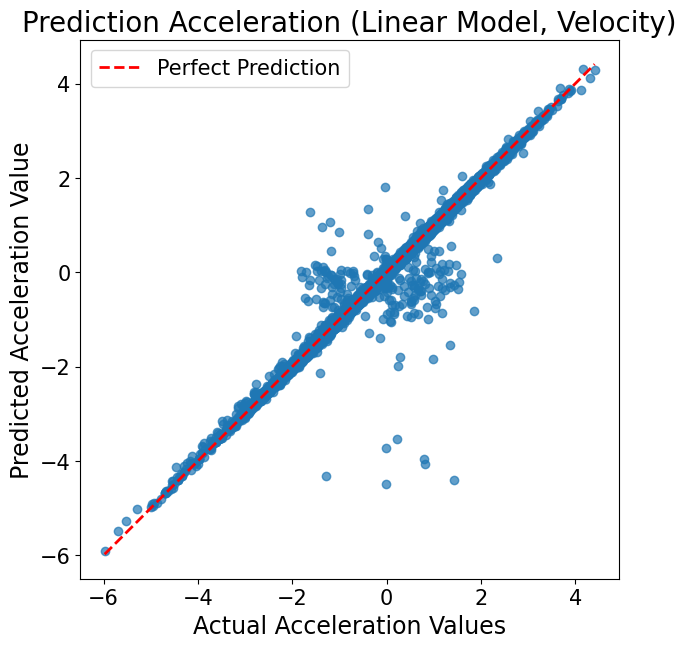

In [5]:
# Input features velocity model 
A = v_x_2 - v_x_1        
B = v_y_2 - v_y_1        
C = - a_x_0
D = - a_y_0
X_velocity_model = np.vstack((
    np.column_stack((A, C)),
    np.column_stack((B, D))
))
print(X_velocity_model.shape)

# velocity model
velocity_model = perform_linear_regression(X_velocity_model, y, 'Prediction Acceleration (Linear Model, Velocity)')

(410546, 2)
Mean Squared Error (MSE): 3.5370e-03
Mean Absolute Error (MAE): 1.1877e-02
R-squared (R²) Score: 9.8918e-01


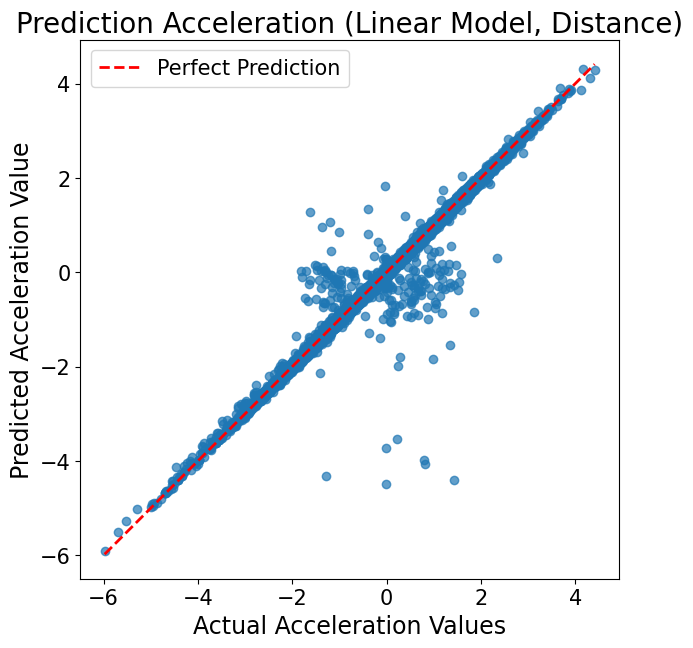

In [6]:
# Input features X_second_model of the second model
dt = 0.04
A = s_x_2 - s_x_1 - v_x_1        
B = s_y_2 - s_y_1 - v_y_1        
C = - a_x_0                                 
D = - a_y_0                                 

X_distance_model = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
))
print(X_distance_model.shape)

# distance model
distance_model = perform_linear_regression(X_distance_model, y, 'Prediction Acceleration (Linear Model, Distance)')


## Comparison of the acceleration results of the first and second model

Mean Squared Error (MSE): 1.8141e-06
Mean Absolute Error (MAE): 7.5061e-04
R-squared (R²) Score: 9.9999e-01


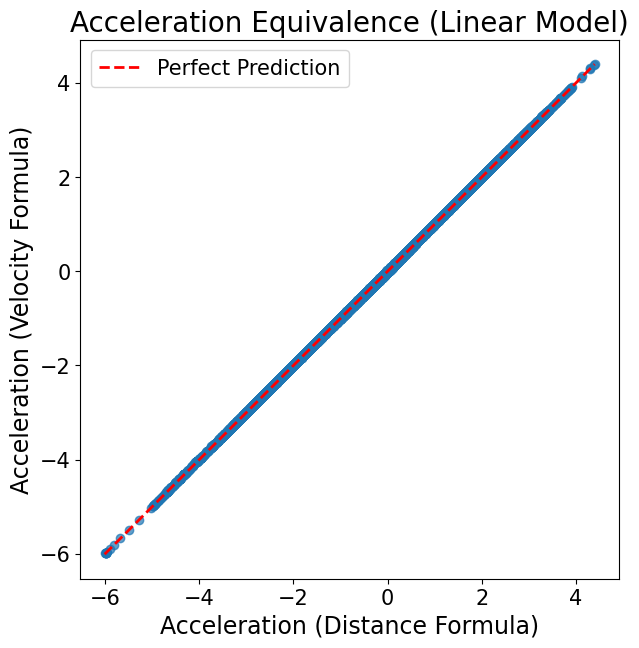

In [7]:
y_pred_distance_model =  distance_model.predict(X_distance_model)
y_pred_velocity_model =  velocity_model.predict(X_velocity_model)

evaluate_and_save( y_pred_distance_model, y_pred_velocity_model, 'Acceleration Equivalence (Linear Model)', 'Acceleration (Distance Formula)', 'Acceleration (Velocity Formula)')

# Run the integration (Baackwards step)

In [8]:
# Extracting coefficients from the models
c_1_overline = distance_model.coef_[0]
c_2_overline = distance_model.coef_[1]
c_3_overline = velocity_model.coef_[0]
c_4_overline = velocity_model.coef_[1]

# Calculating inverse coefficients for later use
c_1 = 1 / c_1_overline
c_2 = c_2_overline * c_1
c_3 = 1 / c_3_overline
c_4 = c_4_overline * c_3

Mean Squared Error (MSE): 2.2635e+00
Mean Absolute Error (MAE): 1.5045e+00
R-squared (R²) Score: 9.3378e-01


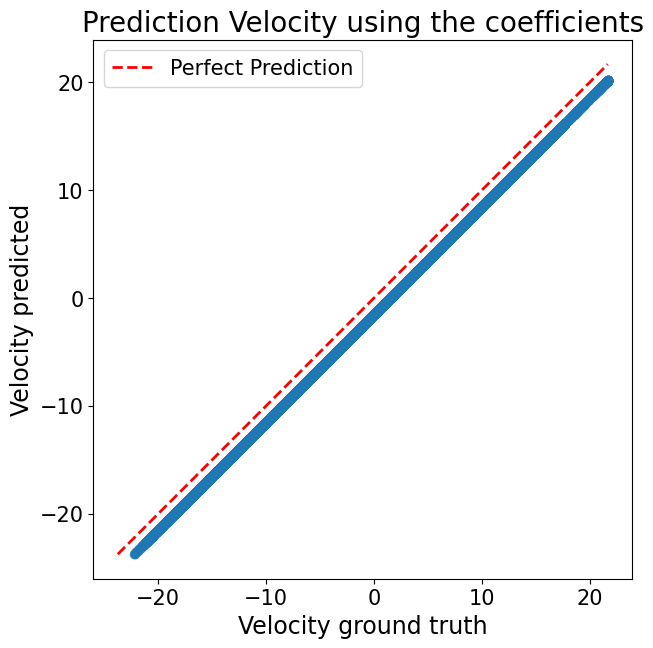

In [11]:
# Prediction using the velocity model
a_xy_1_pred_velocity_model = velocity_model.predict(X_velocity_model)

# Splitting the predictions for x and y components
half = int(len(a_xy_1_pred_velocity_model) / 2)
a_x_1_pred = a_xy_1_pred_velocity_model[:half]
a_y_1_pred = a_xy_1_pred_velocity_model[half:]

# Predicting velocity for the next time step
v_x_2_pred = v_x_1 + c_3 * a_x_1_pred + c_4 * a_x_0
v_y_2_pred = v_y_1 + c_3 * a_y_1_pred + c_4 * a_y_0


# Evaluating the predictions but concate results
v_xy_2 = np.concatenate((v_x_2, v_y_2))
v_xy_2_pred = np.concatenate((v_x_2_pred, v_y_2_pred))

evaluate_and_save(v_xy_2, v_xy_2_pred, 'Prediction Velocity using the coefficients', xlabel='Velocity ground truth', ylabel='Velocity predicted')


Mean Squared Error (MSE): 1.3867e+01
Mean Absolute Error (MAE): 3.7239e+00
R-squared (R²) Score: 9.8926e-01


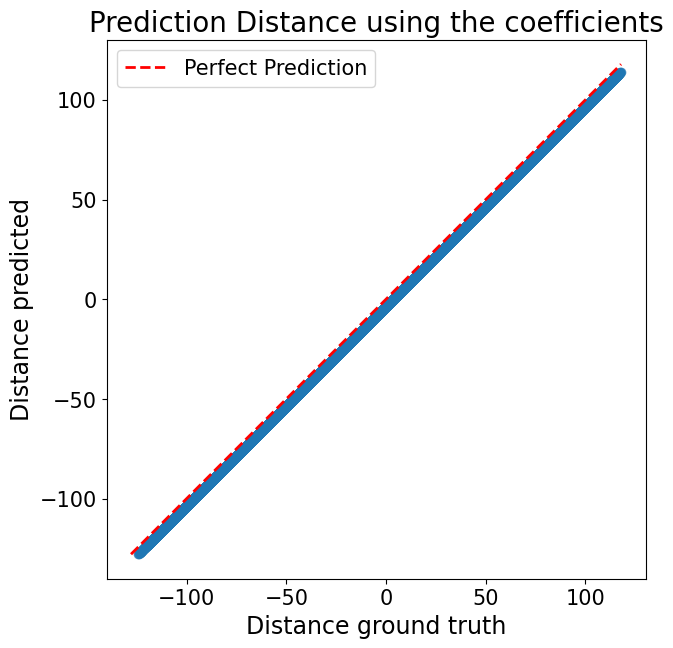

In [12]:
# Prediction using the velocity model
a_xy_1_pred_distance_model = distance_model.predict(X_distance_model)

# Splitting the predictions for x and y components
half = int(len(a_xy_1_pred_distance_model) / 2)
a_x_1_pred_dist = a_xy_1_pred_distance_model[:half]
a_y_1_pred_dist = a_xy_1_pred_distance_model[half:]


# Predicting velocity for the next time step
s_x_2_pred = s_x_1 + v_x_1 + c_1 * a_x_1_pred_dist + c_2 * a_x_0
s_y_2_pred = s_y_1 + v_y_1 + c_1 * a_y_1_pred_dist + c_2 * a_y_0

# Evaluating the predictions but concate results
s_xy_2 = np.concatenate((s_x_2, s_y_2))
s_xy_2_pred = np.concatenate((s_x_2_pred, s_y_2_pred))

evaluate_and_save(s_xy_2, s_xy_2_pred, 'Prediction Distance using the coefficients', xlabel='Distance ground truth', ylabel='Distance predicted')
